first, let's import all packages needed for this section. Socrata is the library for using sodapy, which will connect us to the data source

In [18]:
import pandas as pd
from sodapy import Socrata
import datetime
import matplotlib.pyplot as plt
import numpy as np

set up connection to data source. the app token is associated with an individual user's application, so mine is hidden. but they are free to obtain via data sfdata

the ID for the "fire-department-calls-for-service" dataset is 'nuek-vuh3' whihc sets up a connection to that dataset specifically

In [19]:
domain = 'data.sfgov.org'
app_token = 'rrmNGKZrjY8MyQ07z8MxjVxHs'

In [20]:
client = Socrata("data.sfgov.org", app_token, timeout = 30)
dataset = 'nuek-vuh3'

let's start by making sure we're in the right place. we can obtain the metadata for the dataset using the get_metadata() method. then store the names of all the fields in a list, so we can pick for them later

In [21]:

metadata = client.get_metadata(dataset)
columns = metadata.get('columns')
fieldNames = [col['fieldName'] for col in columns]
fieldNames

['call_number',
 'unit_id',
 'incident_number',
 'call_type',
 'call_date',
 'watch_date',
 'received_dttm',
 'entry_dttm',
 'dispatch_dttm',
 'response_dttm',
 'on_scene_dttm',
 'transport_dttm',
 'hospital_dttm',
 'call_final_disposition',
 'available_dttm',
 'address',
 'city',
 'zipcode_of_incident',
 'battalion',
 'station_area',
 'box',
 'original_priority',
 'priority',
 'final_priority',
 'als_unit',
 'call_type_group',
 'number_of_alarms',
 'unit_type',
 'unit_sequence_in_call_dispatch',
 'fire_prevention_district',
 'supervisor_district',
 'neighborhoods_analysis_boundaries',
 'location',
 'rowid',
 ':@computed_region_rxqg_mtj9',
 ':@computed_region_yftq_j783',
 ':@computed_region_jx4q_fizf',
 ':@computed_region_ajp5_b2md',
 ':@computed_region_bh8s_q3mv',
 ':@computed_region_fyvs_ahh9',
 ':@computed_region_p5aj_wyqh',
 ':@computed_region_n4xg_c4py',
 ':@computed_region_fcz8_est8',
 ':@computed_region_h4ep_8xdi']

fortunately/unfortunately, the API only lets a free user obtain 1000 per call. so in order to get all the data we want, we will need to make several calls and store the results in a list. we know we're going to need to do this a few times, so let's write a quick function for it. 

In [22]:
def getAll(domain, app_token, dataset,fieldList,limit):
    
    client = Socrata(domain, app_token, timeout = 30)    
    results = list()
    
    for i in range(limit):        
        incoming = client.get(dataset, select = fieldList, offset = i*1000)
        results.append(incoming)
       
        if len(incoming)<1000:
            break
        pctComplete = 100* (len(results)/limit)
        if pctComplete % 10==0:
            print('percent complete :',pctComplete,  ' %')
            
    return results

to get it working, let's define a fieldList and run it. recall that the list of fields we are selecting matches the list of fields that the course has chosen as the ones most pertinent to making predictions of response time.

In [23]:
fieldList = 'received_dttm, dispatch_dttm, response_dttm, call_Type, fire_prevention_district, neighborhoods_analysis_boundaries, number_of_alarms, original_priority, priority, unit_type, rowid'

In [24]:
results = getAll(domain,app_token,dataset,fieldList,limit=100)

percent complete : 10.0  %
percent complete : 20.0  %
percent complete : 30.0  %
percent complete : 40.0  %
percent complete : 50.0  %
percent complete : 60.0  %
percent complete : 70.0  %
percent complete : 80.0  %
percent complete : 90.0  %
percent complete : 100.0  %


inconveniently, the results are stored in a list, with each element being a JSON string with 1000 records in it. so we need a function to loop through that and make a dataframe out of all the records

In [25]:
def jsonToDF(json_results):
    results_df = pd.DataFrame()
    for i in range(len(json_results)):
        
        results_df= results_df.append(pd.DataFrame.from_records(json_results[i]), sort = False)
    return results_df
            

In [26]:
results_df = jsonToDF(results) 
results_df

,received_dttm,dispatch_dttm,response_dttm,call_Type,fire_prevention_district,neighborhoods_analysis_boundaries,number_of_alarms,original_priority,priority,unit_type,rowid
0,2020-06-04T00:00:17.000,2020-06-04T00:02:09.000,2020-06-04T00:02:13.000,Medical Incident,None,Treasure Island,1,3,2,MEDIC,201560006-86
1,2020-06-04T00:00:17.000,2020-06-04T00:02:09.000,2020-06-04T00:04:08.000,Medical Incident,None,Treasure Island,1,3,2,ENGINE,201560006-E48
2,2020-06-04T00:00:17.000,2020-06-04T00:02:09.000,2020-06-04T00:04:12.000,Medical Incident,None,Treasure Island,1,3,2,MEDIC,201560006-RA48
3,2020-06-04T00:03:15.000,2020-06-04T00:05:48.000,2020-06-04T00:06:04.000,Medical Incident,6,Bernal Heights,1,2,2,MEDIC,201560012-94
4,2020-06-04T00:09:59.000,2020-06-04T00:11:53.000,2020-06-04T00:13:50.000,Outside Fire,3,Financial District/South Beach,1,3,3,ENGINE,201560019-E01
...,...,...,...,...,...,...,...,...,...,...,...
995,2019-12-13T12:39:47.000,2019-12-13T12:42:33.000,2019-12-13T12:44:52.000,Elevator / Escalator Rescue,9,West of Twin Peaks,1,3,3,TRUCK,193471778-T15
996,2019-12-14T12:53:55.000,2019-12-14T12:57:01.000,2019-12-14T12:58:10.000,Medical Incident,9,West of Twin Peaks,1,2,2,ENGINE,193481776-E33
997,2019-10-03T14:54:35.000,2019-10-03T14:56:15.000,2019-10-03T14:56:21.000,Medical Incident,3,South of Market,1,3,3,MEDIC,192762497-77
998,2019-12-18T02:03:23.000,2019-12-18T02:05:57.000,2019-12-18T02:07:23.000,Medical Incident,4,Western Addition,1,2,3,ENGINE,193520192-E38


because we didn't specify it, pandas assumes string objects for all columns in the dataframe. so now let's explicitly tell it what data type each column should be

In [27]:
dataTypeDict = {'received_dttm':'datetime64',
                'dispatch_dttm':'datetime64',
                'response_dttm':'datetime64',
                'call_Type':'str',
                'fire_prevention_district':'str',
                'neighborhoods_analysis_boundaries':'str',
                'number_of_alarms':'int',
                'original_priority':'str',
                'priority':'str',
                'unit_type':'str'}    
results_df = results_df.astype(dataTypeDict)

now we can do some preliminary math on the dataframe to get the target variable. recall that in the course, they called this "timeDelay" and defined it as "response time" - "received time". i have decided to call this "response duration" as i think it is a more descriptive and accurate name for the variable. i'll also calculate a field called "travel time" defined as "dispatch_dttm" - "response_dttm". just for fun. also, pandas will automatically store these as the "timedelta" datatype. which i think would be fine, but for simplicity of the ML model, let's convert them to minutes (as floats)

In [28]:
results_df['response duration'] = results_df['response_dttm'] - results_df['received_dttm']
results_df['response duration'] = results_df['response duration']/np.timedelta64(1,'s')/60

In [29]:
results_df['travel time'] = results_df['response_dttm'] - results_df['dispatch_dttm']
results_df['travel time'] = results_df['travel time']/np.timedelta64(1,'s')/60

In [30]:
results_df.dtypes
        

received_dttm                        datetime64[ns]
dispatch_dttm                        datetime64[ns]
response_dttm                        datetime64[ns]
call_Type                                    object
fire_prevention_district                     object
neighborhoods_analysis_boundaries            object
number_of_alarms                              int32
original_priority                            object
priority                                     object
unit_type                                    object
rowid                                        object
response duration                           float64
travel time                                 float64
dtype: object

to get a sense of the distribution of the data we're dealing with, let's have a look at a histogram

C:\Users\admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.7286e+04, 4.1600e+02, 1.0700e+02, 3.5000e+01, 4.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-144.36666667, -115.75888889,  -87.15111111,  -58.54333333,
         -29.93555556,   -1.32777778,   27.28      ,   55.88777778,
          84.49555556,  113.10333333,  141.71111111,  170.31888889,
         198.92666667,  227.53444444,  256.14222222,  284.75      ,
         313.35777778,  341.96555556,  370.57333333,  399.18111111,
         427.78888889,  456.39666667,  485.00444444,  513.61222222,
         542.22      ,  570.82777778,  599.43555556,  628.04333333,
         656.65111111,  685.25888889,  713.86666667]),
 <a list of 30 Patch objects>)

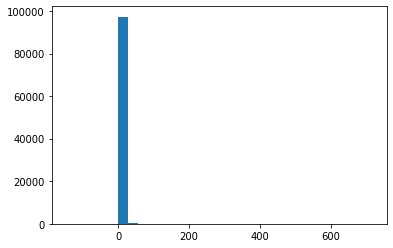

In [31]:
plt.hist(results_df['response duration'], bins = 30)

looks like a pretty skewed distribution, with most values between 0 and 20 minutes. and a few much longer. so let's do as the course does and only focus on the values between 0 and 15 minutes, assuming the others are outliers that will hurt more than help our model.

i acknowledge that sometimes outliers are significant and we want our model to be able to learn from the fact that they are there, so i may remove this restriction later.

(array([ 3261.,  5449.,  7467.,  9674., 11904., 12855., 11656.,  9501.,
         7036.,  4824.,  3353.,  2252.,  1638.,  1124.,   801.,   635.,
          460.,   369.,   330.,   296.,   224.,   204.,   180.,   143.,
          143.,   121.,   102.,   109.,    94.,    82.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ]),
 <a list of 30 Patch objects>)

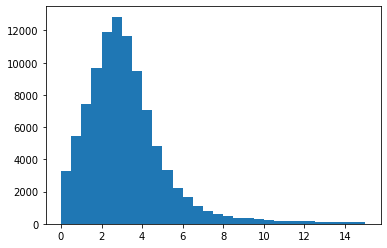

In [32]:
temp = results_df[results_df['response duration'].between(0,15)]
plt.hist(temp['response duration'], bins = 30)

with this filtering applied, we now a very pretty distribution, with a healthy mean right around 3 minutes

this concludes the data import section. we will now store the results_df variable so we can use it in the next notebook, which cleans the data, explores it, and builds the models

In [33]:
%store results_df

Stored 'results_df' (DataFrame)
